# The Algorithmic Beauty of Plants

This F# notebook contains implementations, examples, drawings, etc. of the Lindenmayer systems (L-systems) described in the book *The Algorithmic Beauty of Plants* by Przemyslaw Prusinkiewicz and Aristid Lindenmayer. [The book is officially available for free as a PDF.](http://algorithmicbotany.org/papers/#abop)

### Dependencies

In [177]:
#r "nuget: SkiaSharp"

open SkiaSharp

Installed Packages SkiaSharp, 2.88.3

### Utilities

In [178]:
/// Represents angles in degrees
[<Measure>] type degrees

/// Represents angles in radians
[<Measure>] type radians

/// Removes any units of measure from the given float
let inline removeUnits (x: float<_>) = float x

/// Converts the angle in degrees to radians
let convertDegreesToRadians (degrees: float<degrees>) =
    (degrees * System.Math.PI / 180.0<degrees>) * 1.0<radians>

### Deterministic Context Free (DOL) System

In Section 1.2 on pages 3-6, DOL-systems are described.

**Definition**: Let $V$ denote an alphabet, $V^*$ the set of all words over $V$, and $V^+$ the set of all nonempty words over $V$. A *string OL-system* is an ordered triplet $G = \langle V, \omega, P \rangle$ where $V$ is the *alphabet* of the system, $\omega\in V^+$ is a nonempty word called the *axiom* and $P\subset V\times V^*$ is a finite *set of productions*. A production $(a, \chi)\in P$ is written as $a \to \chi$. The letter $a$ and the word $\chi$ are called the *predecessor* and the *successor* of this production, respectively. It is assumed that for any letter $a\in V$, there is at least one word $\chi\in V^*$ such that $a\to \chi$. If no production is explicitly specified for a given predecessor $a\in V$, the *identity production* $a \to a$ is assumed to belong to the set of productions $P$. An OL-system is *deterministic* (noted *DOL-system*) if and only if for each $a\in V$ there is exactly one $\chi\in V^*$ such that $a\to V$.

In [179]:
type Production =
    { Predecessor: char
      Successor: string }

let production predecessor successor =
    { Predecessor = predecessor
      Successor = successor }

type DOLSystem =
    { Alphabet: char list
      Axiom: string
      Productions: Production list }

let verifyDeterminism dol =
    let predecessors =
        dol.Productions
        |> List.map (fun p -> p.Predecessor)
    (List.length predecessors) = (predecessors |> List.distinct |> List.length)

let rewriteCharacter productions character =
    match List.tryFind (fun p -> p.Predecessor = character) productions with
    | Some {Successor = sucessor} -> sucessor
    | None -> string character

let rewriteWord productions (word: string) =
    let stringSequence = Seq.map (rewriteCharacter productions) word
    String.Join("", stringSequence)

let iterate n dol =
    List.fold (fun word _ -> rewriteWord dol.Productions word) dol.Axiom [1..n]

let printIterations n dol =
    for i in [0..n] do
        printfn "%s" (iterate i dol)

let testProduction character =
    match character with
    | 'b' -> "ad"
    | 'a' -> "cb"
    | 'd' -> "b"
    | 'c' -> "a"
    | x   -> string x

In [180]:
let inline (=>) (predecessor: char) (successor: string) =
    production predecessor successor

The following DOL-system example is that found in (1.1). In the current implementation of `DOLSystem`, we cannot represent characters such as $a_r$ since we are restricted to an alphabet consisting only of characters. To do something like `a_r` would required extending alphabet entries to strings, which would require more complex modeling and logic than we currently have in place. So, for now, $a_l$ is `a`, $a_r$ is `b`, $b_l$ is `c`, and $b_r$ is `d`.

In [181]:
let dol =
    { Alphabet = ['a'; 'b'; 'c'; 'd']
      Axiom = "b"
      Productions =
        [ 'b' => "ad"
          'a' => "cb"
          'd' => "b"
          'c' => "a" ] }

printIterations 4 dol

b
ad
cbb
aadad
cbcbbcbb


In [182]:
let dol =
    { Alphabet = ['a'; 'b'; 'c'; 'd']
      Axiom = "b"
      Productions =
        [ 'b' => "ad"
          'a' => "cb"
          'd' => "b"
          'c' => "a" ] }

printIterations 4 dol

b
ad
cbb
aadad
cbcbbcbb


We can use `MathString` provided by .NET Interactive to display a $\LaTeX$ string and reproduce the output in the book on page 5.

In [183]:
[ for n in [0..4] ->
    (iterate n dol)
        .Replace("a", "a_l")
        .Replace("b", "a_r")
        .Replace("c", "b_l")
        .Replace("d", "b_r") ]
|> (fun s -> String.Join(@"\newline ", s))
|> MathString

In [184]:
let quadraticKochIsland =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "F-F+F+FF-F-F+F" ] }

printIterations 1 quadraticKochIsland

F-F-F-F
F-F+F+FF-F-F+F-F-F+F+FF-F-F+F-F-F+F+FF-F-F+F-F-F+F+FF-F-F+F


In [185]:
type Coordinate =
    { X: float
      Y: float }

type TurtleCommand =
    | ForwardWithPenDown
    | ForwardWithPenUp
    | RotateRight
    | RotateLeft

type Turtle =
    { Coordinate: Coordinate
      Heading: float<degrees>
      StepSize: float
      AngleIncrement: float<degrees> }

let defaultTurtle =
    { Coordinate = {X = 0.0; Y = 0.0}
      Heading = 90.0<degrees>
      StepSize = 10.0
      AngleIncrement = 90.0<degrees> }

let handleCommand state command =
    match command with
    | ForwardWithPenDown ->
        let nextX = state.Coordinate.X + state.StepSize * cos (state.Heading |> convertDegreesToRadians |> removeUnits)
        let nextY = state.Coordinate.Y + state.StepSize * sin (state.Heading |> convertDegreesToRadians |> removeUnits)
        { state with Coordinate = {X = nextX; Y = nextY} }
    | ForwardWithPenUp ->
        let nextX = state.Coordinate.X + state.StepSize * cos (state.Heading |> convertDegreesToRadians |> removeUnits)
        let nextY = state.Coordinate.Y + state.StepSize * sin (state.Heading |> convertDegreesToRadians |> removeUnits)
        { state with Coordinate = {X = nextX; Y = nextY} }
    | RotateRight ->
        { state with Heading = state.Heading - state.AngleIncrement }
    | RotateLeft ->
        { state with Heading = state.Heading + state.AngleIncrement }

let drawTurtle (path: SKPath) command state =
    let newState = handleCommand state command
    match command with
    | ForwardWithPenDown ->
        path.LineTo(single newState.Coordinate.X, single newState.Coordinate.Y)
        newState
    | ForwardWithPenUp ->
        path.MoveTo(single newState.Coordinate.X, single newState.Coordinate.Y)
        newState
    | RotateRight ->
        newState
    | RotateLeft ->
        newState

let calculateExtremeCoordinates initialTurtle commands =
    let handleState (turtle, minX, minY, maxX, maxY) command =
        let newTurtle = handleCommand turtle command
        (newTurtle,
         min minX newTurtle.Coordinate.X,
         min minY newTurtle.Coordinate.Y,
         max maxX newTurtle.Coordinate.X,
         max maxY newTurtle.Coordinate.Y)
    let (_, minX, minY, maxX, maxY) =
        let initialState = (initialTurtle,
                            initialTurtle.Coordinate.X,
                            initialTurtle.Coordinate.Y,
                            initialTurtle.Coordinate.X,
                            initialTurtle.Coordinate.Y)
        List.fold handleState initialState commands
    {| Minimum = {X = minX; Y = minY}; Maximum = {X = maxX; Y = maxY} |}

let normalizeStepSize desiredWidth desiredHeight turtle commands =
    let extremeCoordinates = calculateExtremeCoordinates turtle commands
    let {Coordinate.X = minX; Y = minY} = extremeCoordinates.Minimum
    let {Coordinate.X = maxX; Y = maxY} = extremeCoordinates.Maximum
    let maxDimension = max (maxX - minX) (maxY - minY)
    let newStepSize = (max desiredWidth desiredHeight) * turtle.StepSize / maxDimension
    { turtle with StepSize = newStepSize }

let width  = 500.0
let height = 500.0
let margin = 10.0

let drawSystem (canvas: SKCanvas) initialTurtle commands =
    let turtle = normalizeStepSize width height initialTurtle commands
    let extremeCoordinates = calculateExtremeCoordinates turtle commands
    let {Coordinate.X = minX; Y = minY} = extremeCoordinates.Minimum
    let {Coordinate.X = maxX; Y = maxY} = extremeCoordinates.Maximum

    let turtleColor = SKColors.Black
    use turtlePaint = new SKPaint(
        Style = SKPaintStyle.Stroke,
        Color = SKColors.Black,
        StrokeWidth = 1.5f,
        IsAntialias = true)
    use originPaint = new SKPaint(
        Style = SKPaintStyle.StrokeAndFill,
        Color = SKColors.LawnGreen,
        StrokeWidth = 10.0f,
        StrokeCap = SKStrokeCap.Round)

    canvas.Clear(SKColors.WhiteSmoke)

    // The SkiaSharp canvas coordinates are such that the origin (0, 0) is in the
    // top-left and x increases to the right and y increases downward.
    //
    // The turtle coordinates are standard coordinates such that the origin (0, 0)
    // is in the center and x increases to the right and y increases upward.
    //
    // Thus, we do three transformations:

    // 1. Translate the origin so that we can fit the entire system on
    // the final canvas
    canvas.Translate(single -minX, single maxY)

    // 2. Rotate the axis 180 degrees. This rotates
    // ┌-----> x
    // |
    // |
    // v
    // y
    //
    // to
    //
    //         y
    //         ^
    //         |
    //         |
    // x <-----┘
    canvas.RotateDegrees(180.0f)

    // 3. Flip accross the y-axis
    // y
    // ^
    // |
    // |
    // └-----> x
    canvas.Scale(-1.0f, 1.0f)

    // Draw the starting point of the turtle with a green semi-transparent circle
    canvas.DrawPoint(single turtle.Coordinate.X, single turtle.Coordinate.Y, originPaint)

    use path = new SKPath()

    // Move the turtle to the starting point without drawing a line
    path.MoveTo(single turtle.Coordinate.X, single turtle.Coordinate.Y)

    let mutable state = turtle

    // Draw every command, passing the new state to the next iteration
    for command in commands do
        state <- drawTurtle path command state

    // Draw the constructed path onto the canvas
    canvas.DrawPath(path, turtlePaint)

In [186]:
let convertTurtleStringToCommands (s: string) =
    [for c in s.Replace(" ", String.Empty) ->
        match c with
        | 'F' -> ForwardWithPenDown
        | 'f' -> ForwardWithPenUp
        | '+' -> RotateLeft
        | '-' -> RotateRight
        | _ -> raise (System.Exception "invalid turtle character")]

let drawTurtleSystem n initialTurtle dol : SKBitmap =
    let commands =
        dol
        |> iterate n
        |> convertTurtleStringToCommands

    // Create a bitmap of the desiered width and height plus margins
    let bitmap = new SKBitmap(int width + 2 * int margin, int height + 2 * int margin)
    
    // Create a canvas that we will draw to the bitmap with
    use canvas = new SKCanvas(bitmap)

    // Translate the canvas so that what we draw to is contained within the margins
    canvas.Translate(single margin, single margin)
    
    drawSystem canvas initialTurtle commands
    bitmap


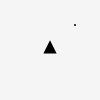

In [187]:
let originPaint = new SKPaint(
        Style = SKPaintStyle.StrokeAndFill,
        Color = SKColors.Black,
        StrokeWidth = 2.0f,
        StrokeCap = SKStrokeCap.Round,
        IsAntialias = true)
let bitmap = new SKBitmap(100, 100)
let canvas = new SKCanvas(bitmap)
canvas.Clear(SKColors.WhiteSmoke)
canvas.Translate(50.0f, 50.0f)
canvas.RotateDegrees(180.0f)
canvas.Scale(-1.0f, 1.0f)
canvas.DrawPoint(25.0f, 25.f, originPaint)
let path = new SKPath()
path.MoveTo(0.0f, -2.5f)
path.LineTo(5.0f, -2.5f)
path.LineTo(0.0f, 7.5f)
path.LineTo(-5.0f, -2.5f)
path.LineTo(0.0f, -2.5f)
canvas.DrawPath(path, originPaint)

bitmap


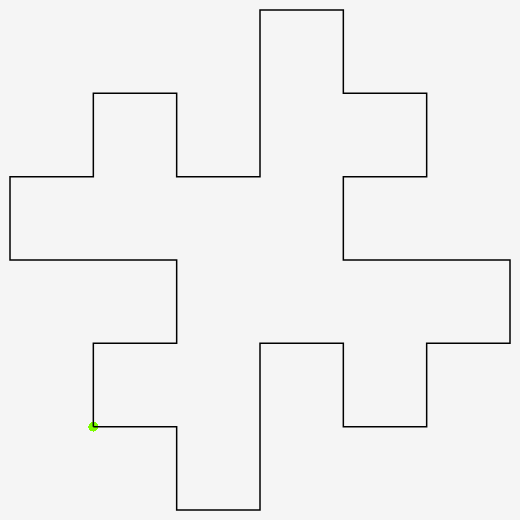

In [188]:
// Figure 1.6 (a)

drawTurtleSystem 1 defaultTurtle quadraticKochIsland


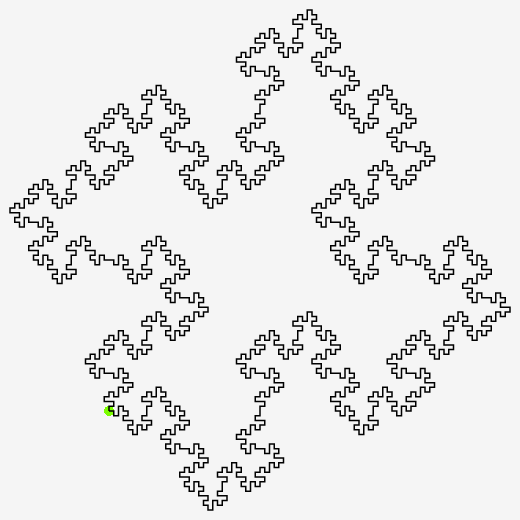

In [189]:
// Figure 1.6 (b)

drawTurtleSystem 3 defaultTurtle quadraticKochIsland


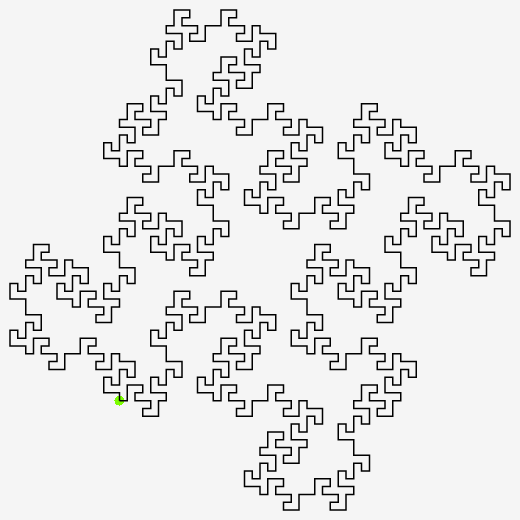

In [190]:
// Figure 1.7 (a)
let quadraticKochIsland =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "F+FF-FF-F-F+F+FF-F-F+F+FF+FF-F" ] }

drawTurtleSystem 2 defaultTurtle quadraticKochIsland


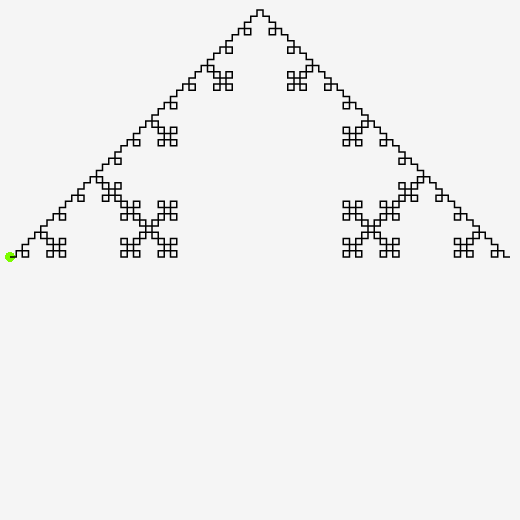

In [191]:
// Figure 1.7 (b)
let quadraticSnowflakeCurve =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "-F"
      Productions =
        [ 'F' => "F+F-F-F+F" ] }

drawTurtleSystem 4 defaultTurtle quadraticSnowflakeCurve


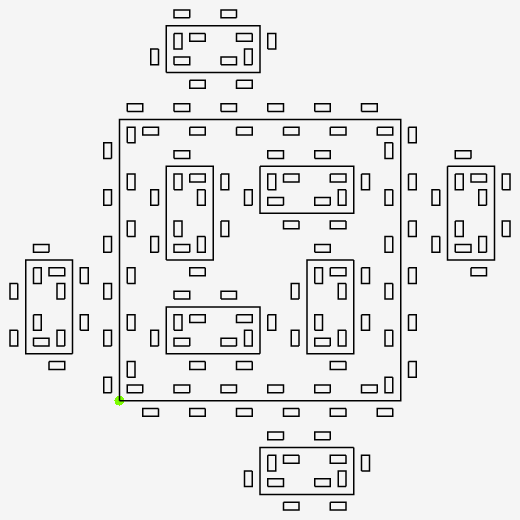

In [192]:
// Figure 1.8
let islandsAndLakes =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "F+f-FF+F+FF+Ff+FF-f+FF-F-FF-Ff-FFF"
          'f' => "ffffff" ] }

drawTurtleSystem 2 defaultTurtle islandsAndLakes


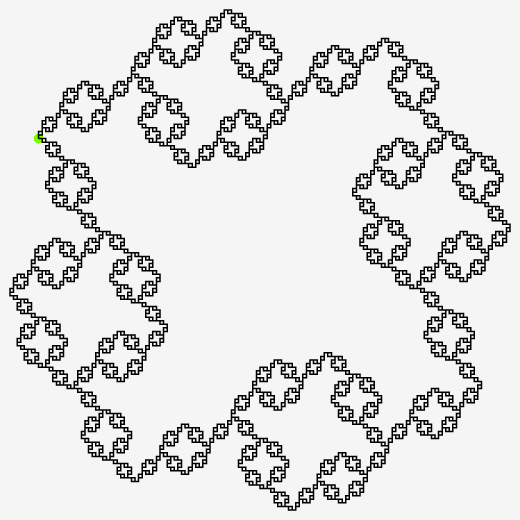

In [193]:
// Figure 1.9 (a)
let kochA =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "FF-F-F-F-F-F+F" ] }

drawTurtleSystem 4 defaultTurtle kochA


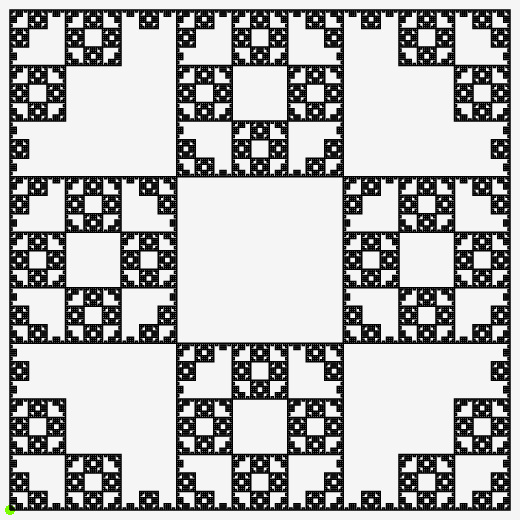

In [194]:
// Figure 1.9 (b)
let kochB =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "FF-F-F-F-FF" ] }

drawTurtleSystem 5 defaultTurtle kochB


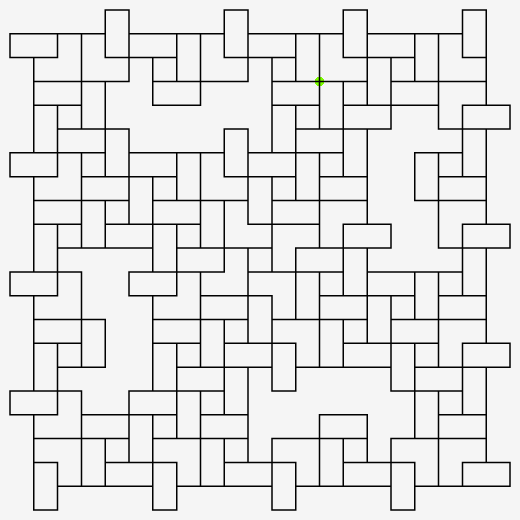

In [195]:
// Figure 1.9 (c)
let kochC =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "FF-F+F-F-FF" ] }

drawTurtleSystem 3 defaultTurtle kochC


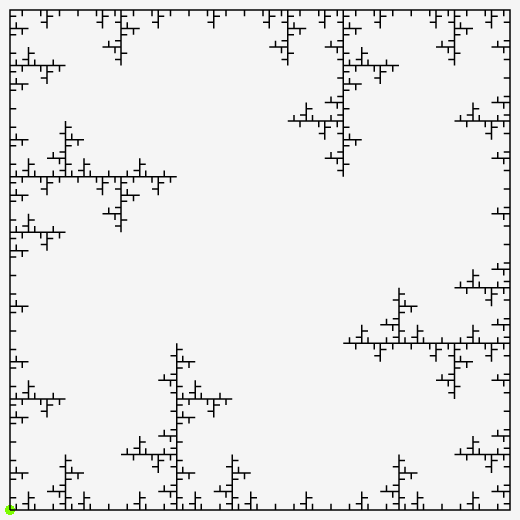

In [196]:
// Figure 1.9 (d)
let kochD =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "FF-F--F-F" ] }

drawTurtleSystem 4 defaultTurtle kochD


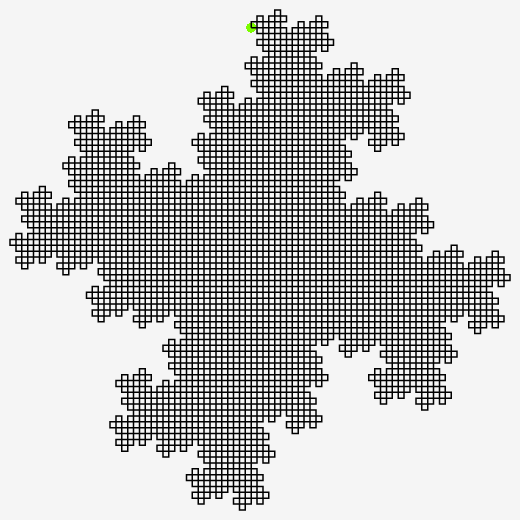

In [197]:
// Figure 1.9 (e)
let kochE =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "F-FF--F-F" ] }

drawTurtleSystem 5 defaultTurtle kochE


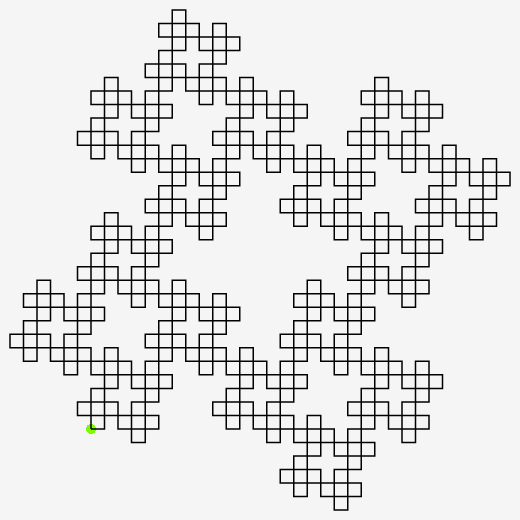

In [198]:
// Figure 1.9 (f)
let kochF =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ 'F' => "F-F+F-F-F" ] }

drawTurtleSystem 4 defaultTurtle kochF

### Edge rewriting

In [199]:
let drawEdgeRewritingSystem n initialTurtle fass =
    let s = iterate n fass
    let turtleSystem = { fass with Axiom = s.Replace('L', 'F').Replace('R', 'F') }
    drawTurtleSystem 0 initialTurtle turtleSystem


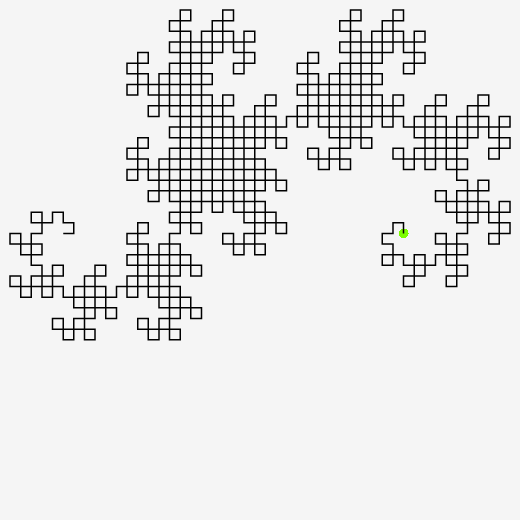

In [200]:
// Figure 1.10 (a)
// dragon curve
let dragonCurve =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "L"
      Productions =
        [ 'L' => "L+R+"
          'R' => "-L-R" ] }

drawEdgeRewritingSystem 10 defaultTurtle dragonCurve


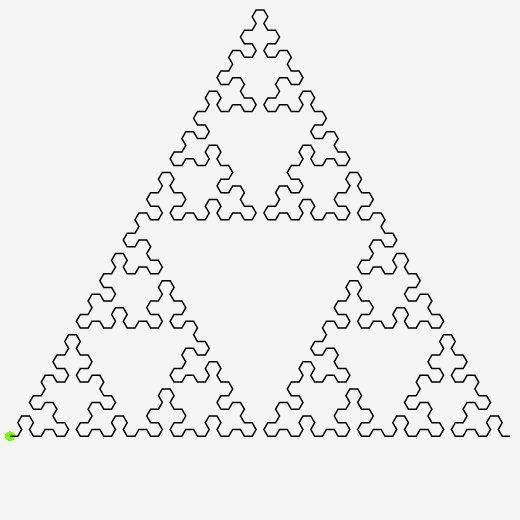

In [201]:
// Figure 1.10 (b)
// Sierpinski gasket
let sierpinskiGasket =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "R"
      Productions =
        [ 'L' => "R+L+R"
          'R' => "L-R-L" ] }

drawEdgeRewritingSystem 6 {defaultTurtle with Heading = 0.0<degrees>; AngleIncrement = 60.0<degrees>} sierpinskiGasket


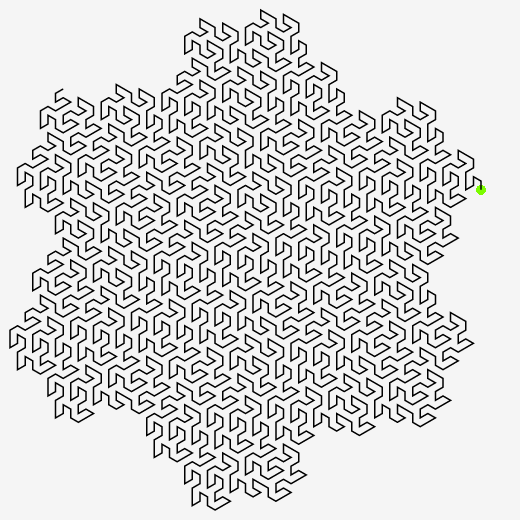

In [202]:
// Figure 1.11 (a)
// hexagonal Gosper curve
let hexagonalGosperCurve =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "L"
      Productions =
        [ 'L' => "L+R++R-L--LL-R+"
          'R' => "-L+RR++R+L--L-R" ] }

drawEdgeRewritingSystem 4 {defaultTurtle with AngleIncrement = 60.0<degrees>} hexagonalGosperCurve


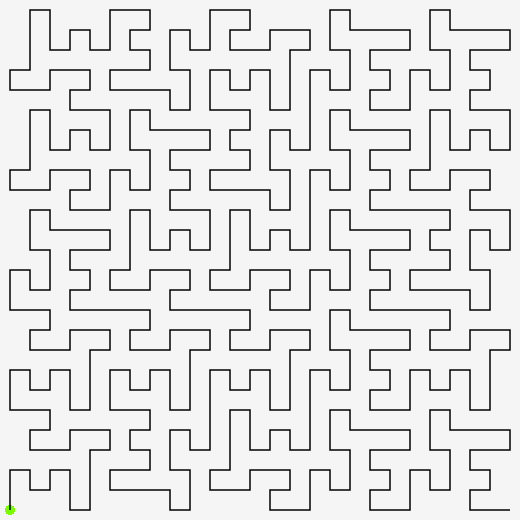

In [203]:
// Figure 1.11 (b)
// quadratic Gospher curve or E-curve
let quadraticGosperCurve =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "-R"
      Productions =
        [ 'L' => "LL-R-R+L+L-R-RL+R+LLR-L+R+LL+R-LR-R-L+L+RR-"
          'R' => "+LL-R-R+L+LR+L-RR-L-R+LRR-L-RL+L+R-R-L+L+RR" ] }

drawEdgeRewritingSystem 2 defaultTurtle quadraticGosperCurve


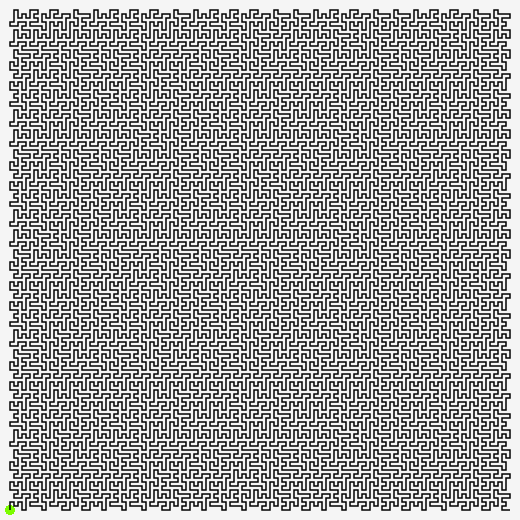

In [204]:
// Figure 1.13 (b)
// 9x9 E-tour
let nineByNineEtour =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "-R"
      Productions =
        [ 'L' => ""
          'R' => "-LL+R+R-L-LR-L+RR+L+R-LRR+L+RL-L-R+R+L-L-RR" ] }

drawEdgeRewritingSystem 3 defaultTurtle quadraticGosperCurve

### Node rewriting

In [205]:
let drawNodeRewritingSystem n initialTurtle fass =
    let s = iterate n fass
    let turtleSystem = { fass with Axiom = s.Replace("L", "").Replace("R", "") }
    drawTurtleSystem 0 initialTurtle turtleSystem


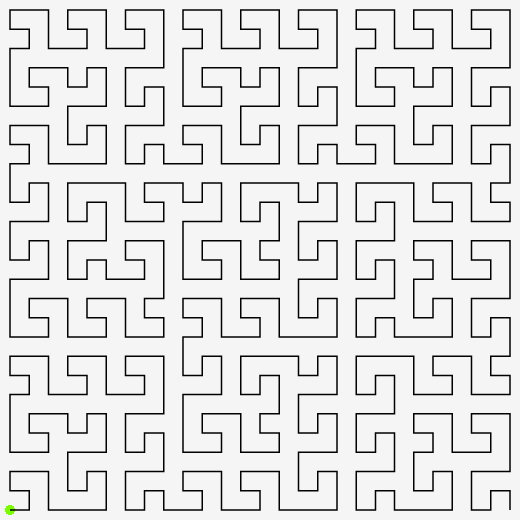

In [206]:
// Figure 1.16 (a)
let threeByThreeMacrotile =
    { Alphabet = ['L'; 'R'; 'F'; '+'; '-']
      Axiom = "-L"
      Productions =
        [ 'L' => "LF+RFR+FL-F-LFLFL-FRFR+"
          'R' => "-LFLF+RFRFR+F+RF-LFL-FR" ] }

drawNodeRewritingSystem 3 defaultTurtle threeByThreeMacrotile


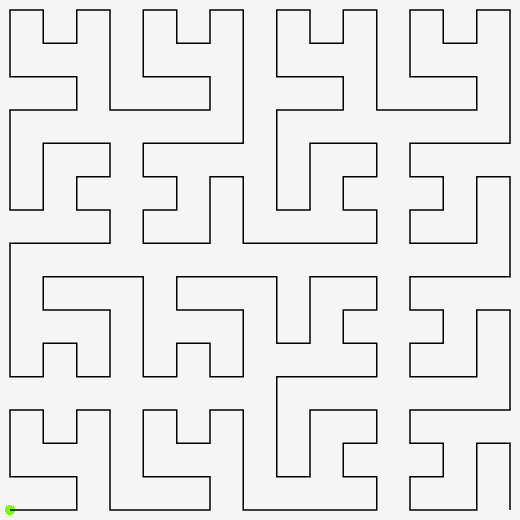

In [207]:
// Figure 1.16 (b)
let fourByFourMacrotile =
    { Alphabet = ['L'; 'R'; 'F'; '+'; '-']
      Axiom = "-L"
      Productions =
        [ 'L' => "LFLF+RFR+FLFL-FRF-LFL-FR+F+RF-LFL-FRFRFR+"
          'R' => "-LFLFLF+RFR+FL-F-LF+RFR+FLF+RFRF-LFL-FRFR" ] }

drawNodeRewritingSystem 2 defaultTurtle fourByFourMacrotile


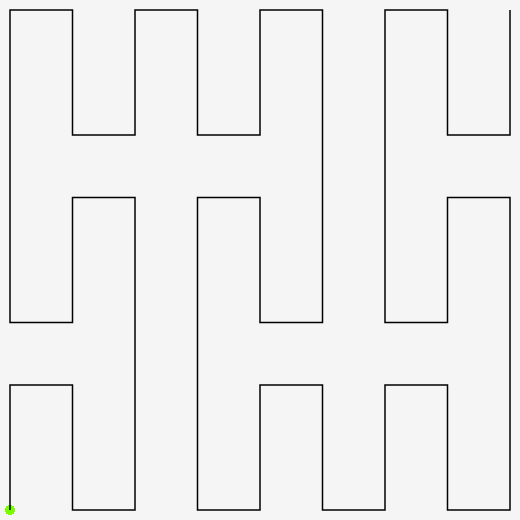

In [208]:
// Figure 1.17 (a)
let threeByThreePeanoCurve =
    { Alphabet = ['L'; 'R'; 'F'; '+'; '-']
      Axiom = "L"
      Productions =
        [ 'L' => "LFRFL-F-RFLFR+F+LFRFL"
          'R' => "RFLFR+F+LFRFL-F-RFLFR" ] }

drawNodeRewritingSystem 2 defaultTurtle threeByThreePeanoCurve


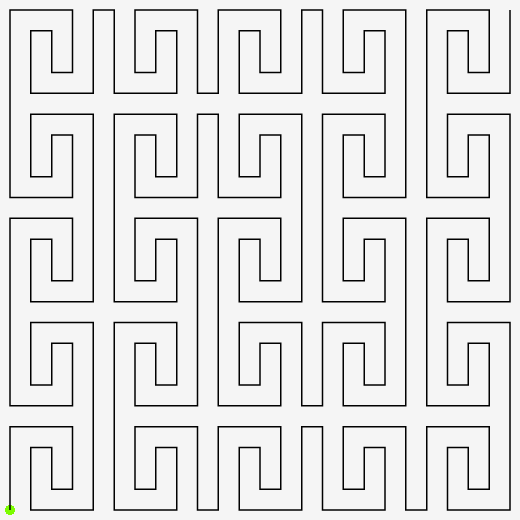

In [209]:
// Note: The book's productions, i.e., the replacement rules, for Figure 1.17(b)
// are incorrect. For one, it leaves off the heading adjustment (alpha), which
// should be 45 degrees. Secondly, the production for L is incorrect. It should
// be what is below.
//
// It was a bit difficult figuring out what the correct rule should be, but one
// way that helped was to reduce down to one iteration. There, one can see that
// the turns are incorrect. Before the incorrect turn though, there is a similar
// turn with the rule `F+R-F-L+F+R+`. From there, one can replace the incorrect
// rule `L-R-F+F+` with `F+R-F-L+F+R+` and then reverse the `L` and `R` placements
// to get `F+L-F-R+F+L+`

// Figure 1.17 (b)
let fiveByFivePeanoCurve =
    { Alphabet = ['L'; 'R'; 'F'; '+'; '-']
      Axiom = "L"
      Productions =
        [ 'L' => "L+F+R-F-L+F+R-F-L-F-R+F+L-F-R-F-L+F+R-F-L-F-R-F-L+F+R+F+L+F+R-F-L+F+R+F+L-F-R+F+L+F+R-F-L+F+R-F-L"
          'R' => "R-F-L+F+R-F-L+F+R+F+L-F-R+F+L+F+R-F-L+F+R+F+L+F+R-F-L-F-R-F-L+F+R-F-L-F-R+F+L-F-R-F-L+F+R-F-L+F+R" ] }

drawNodeRewritingSystem 2 {defaultTurtle with Heading = 45.0<degrees>; AngleIncrement = 45.0<degrees>} fiveByFivePeanoCurve